# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning using CLIP

Fine-tuning is an experiment that involves training the entire model on new data. All of the model's parameters are end-to-end fine-tuned on the provided dataset.

### CLIP (Contrastive Language-Image Pre-Training)

The CLIP model was proposed in *Learning Transferable Visual Models From Natural Language Supervision by Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever*. 

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

https://arxiv.org/abs/2103.0002030

Fine-tuning with CLIP is done by using its vision encoder with an image classification head on top (a linear layer on top of the pooled final hidden states of the patch tokens) e.g. for ImageNet.

https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPForImageClassification

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load CLIP image processor used for image pre-processing. Tokenizer is not needed as the text encoder part of the model is not used.

In [5]:
processor, _ = get_clip_processor_and_tokenizer()

Print the pre-processing operations done by the processor.

In [6]:
processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [15]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [17]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [19]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [21]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

#### DTD

In [23]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for the experiments and print its settings.

In [3]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=2e-5,
    optimizer=AdamW,
    weight_decay=1e-2
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 2e-05,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty arrays to store accuracies for each dataset.

In [25]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning


Train the entire model and all of its parameters on a new dataset.

#### RESISC45

In [26]:
clip_resisc45 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
get_model_params(clip_resisc45)

Parameters: 85.83M


In [28]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 2363/2363 [04:05<00:00,  9.64it/s]


Epochs: 1/10 | train_loss: 0.6686 | train_acc: 0.8026


100%|██████████| 2363/2363 [04:03<00:00,  9.69it/s]


Epochs: 2/10 | train_loss: 0.2933 | train_acc: 0.9097


100%|██████████| 2363/2363 [04:01<00:00,  9.80it/s]


Epochs: 3/10 | train_loss: 0.2034 | train_acc: 0.9352


100%|██████████| 2363/2363 [04:01<00:00,  9.79it/s]


Epochs: 4/10 | train_loss: 0.1687 | train_acc: 0.9474


100%|██████████| 2363/2363 [04:02<00:00,  9.73it/s]


Epochs: 5/10 | train_loss: 0.1482 | train_acc: 0.9548


100%|██████████| 2363/2363 [04:03<00:00,  9.72it/s]


Epochs: 6/10 | train_loss: 0.1211 | train_acc: 0.9623


100%|██████████| 2363/2363 [04:04<00:00,  9.65it/s]


Epochs: 7/10 | train_loss: 0.1163 | train_acc: 0.9652


100%|██████████| 2363/2363 [04:00<00:00,  9.84it/s]


Epochs: 8/10 | train_loss: 0.0929 | train_acc: 0.9708


100%|██████████| 2363/2363 [04:02<00:00,  9.76it/s]


Epochs: 9/10 | train_loss: 0.0914 | train_acc: 0.9707


100%|██████████| 2363/2363 [03:58<00:00,  9.89it/s]


Epochs: 10/10 | train_loss: 0.0851 | train_acc: 0.9734


In [29]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [00:34<00:00, 22.71it/s]

test_loss: 0.4852 | test_acc: 0.8795


In [30]:
resisc45_accs.append(resisc45_acc)

In [31]:
get_top_5_accuracies(resisc45_per_class_acc)

[('baseball diamond', 1.0),
 ('circular farmland', 0.9931506849315068),
 ('parking lot', 0.9925925925925926),
 ('sea ice', 0.9867549668874173),
 ('bridge', 0.9785714285714285)]

In [32]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.6439393939393939),
 ('palace', 0.6642857142857143),
 ('airport', 0.7098765432098766),
 ('church', 0.7482517482517482),
 ('ship', 0.762962962962963)]

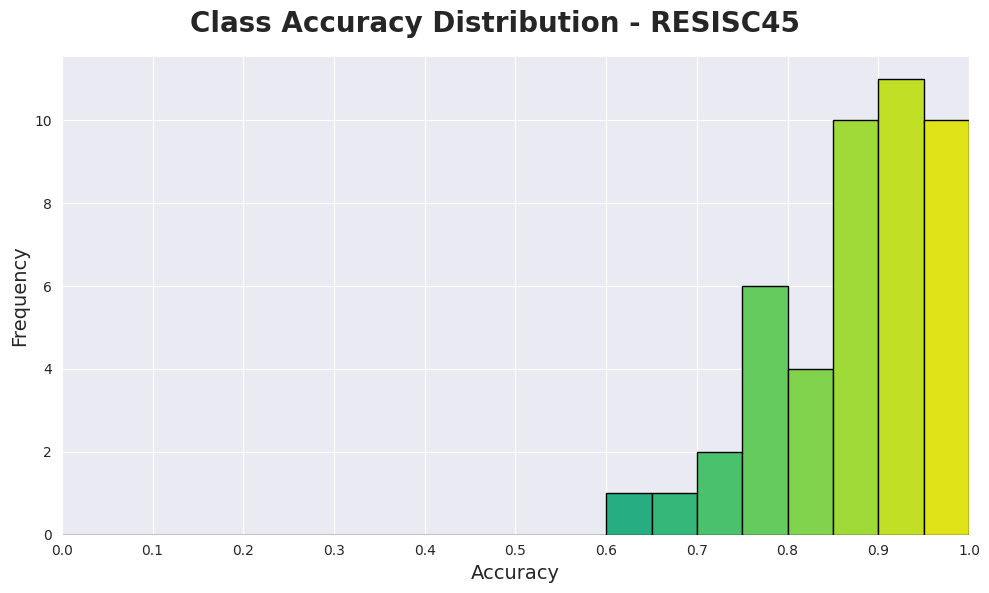

In [33]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [34]:
clip_food101 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
get_model_params(clip_food101)

Parameters: 85.88M


In [36]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

 12%|█▏        | 1176/9469 [02:34<17:05,  8.09it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [19:24<00:00,  8.13it/s]


Epochs: 1/10 | train_loss: 1.5321 | train_acc: 0.6112


100%|██████████| 9469/9469 [19:03<00:00,  8.28it/s]


Epochs: 2/10 | train_loss: 0.7764 | train_acc: 0.7875


100%|██████████| 9469/9469 [19:04<00:00,  8.28it/s]


Epochs: 3/10 | train_loss: 0.5455 | train_acc: 0.8436


100%|██████████| 9469/9469 [18:52<00:00,  8.36it/s]


Epochs: 4/10 | train_loss: 0.4062 | train_acc: 0.8793


100%|██████████| 9469/9469 [18:50<00:00,  8.38it/s]


Epochs: 5/10 | train_loss: 0.3179 | train_acc: 0.9039


100%|██████████| 9469/9469 [19:00<00:00,  8.30it/s]


Epochs: 6/10 | train_loss: 0.2594 | train_acc: 0.9211


100%|██████████| 9469/9469 [18:55<00:00,  8.34it/s]


Epochs: 7/10 | train_loss: 0.2202 | train_acc: 0.9305


100%|██████████| 9469/9469 [18:55<00:00,  8.34it/s]


Epochs: 8/10 | train_loss: 0.1921 | train_acc: 0.9387


100%|██████████| 9469/9469 [19:01<00:00,  8.30it/s]


Epochs: 9/10 | train_loss: 0.1765 | train_acc: 0.9447


100%|██████████| 9469/9469 [18:54<00:00,  8.35it/s]


Epochs: 10/10 | train_loss: 0.1594 | train_acc: 0.9490


In [37]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [03:12<00:00, 16.38it/s]


test_loss: 0.9524 | test_acc: 0.7947


In [38]:
food101_accs.append(food101_acc)

In [39]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.996),
 ('macarons', 0.964),
 ('oysters', 0.96),
 ('spaghetti carbonara', 0.952),
 ('creme brulee', 0.948)]

In [40]:
get_bottom_5_accuracies(food101_per_class_acc)

[('pork chop', 0.344),
 ('apple pie', 0.412),
 ('tuna tartare', 0.416),
 ('huevos rancheros', 0.492),
 ('steak', 0.524)]

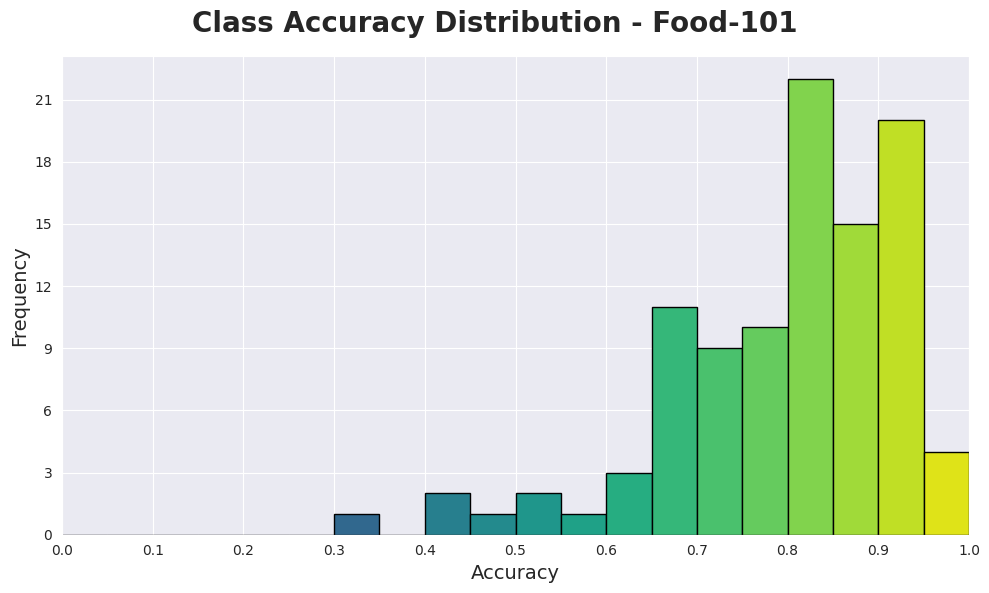

In [41]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [42]:
clip_fer2013 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
get_model_params(clip_fer2013)

Parameters: 85.80M


In [44]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 3589/3589 [05:40<00:00, 10.55it/s]


Epochs: 1/10 | train_loss: 1.1860 | train_acc: 0.5467


100%|██████████| 3589/3589 [05:39<00:00, 10.57it/s]


Epochs: 2/10 | train_loss: 0.9282 | train_acc: 0.6527


100%|██████████| 3589/3589 [05:38<00:00, 10.59it/s]


Epochs: 3/10 | train_loss: 0.8079 | train_acc: 0.6968


100%|██████████| 3589/3589 [05:39<00:00, 10.57it/s]


Epochs: 4/10 | train_loss: 0.6994 | train_acc: 0.7379


100%|██████████| 3589/3589 [05:38<00:00, 10.60it/s]


Epochs: 5/10 | train_loss: 0.5868 | train_acc: 0.7834


100%|██████████| 3589/3589 [05:38<00:00, 10.61it/s]


Epochs: 6/10 | train_loss: 0.4790 | train_acc: 0.8262


100%|██████████| 3589/3589 [05:38<00:00, 10.61it/s]


Epochs: 7/10 | train_loss: 0.3759 | train_acc: 0.8635


100%|██████████| 3589/3589 [05:39<00:00, 10.57it/s]


Epochs: 8/10 | train_loss: 0.2997 | train_acc: 0.8935


100%|██████████| 3589/3589 [05:38<00:00, 10.60it/s]


Epochs: 9/10 | train_loss: 0.2449 | train_acc: 0.9112


100%|██████████| 3589/3589 [05:38<00:00, 10.61it/s]

Epochs: 10/10 | train_loss: 0.2157 | train_acc: 0.9236


In [45]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:15<00:00, 28.33it/s]

test_loss: 1.3107 | test_acc: 0.6865


In [46]:
fer2013_accs.append(fer2013_acc)

In [47]:
fer2013_per_class_acc

{'angry': 0.6211812627291242,
 'disgust': 0.5272727272727272,
 'fear': 0.5359848484848485,
 'happy': 0.906712172923777,
 'sad': 0.5235690235690236,
 'surprise': 0.7524038461538461,
 'neutral': 0.6805111821086262}

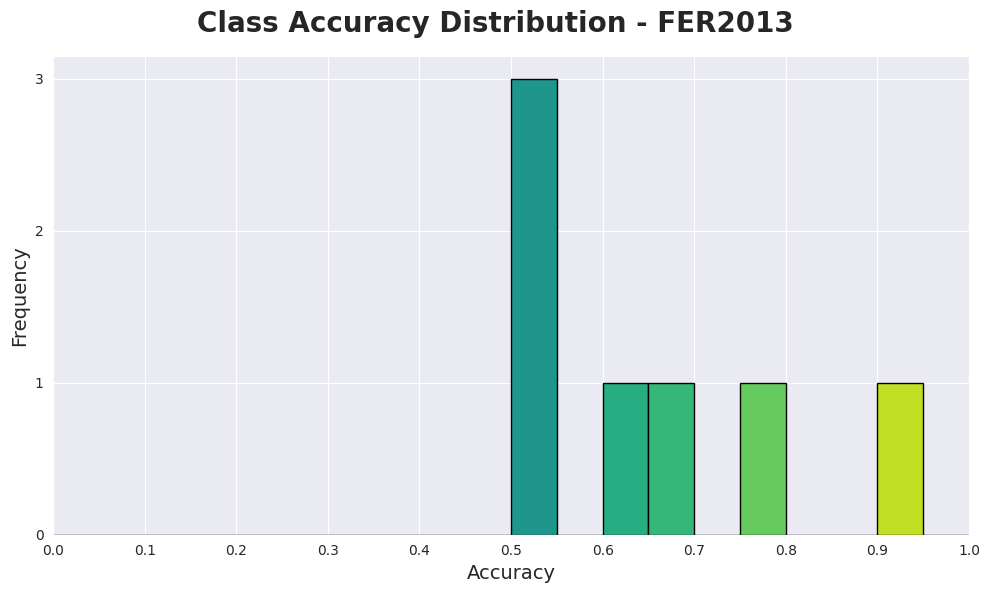

In [48]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [49]:
clip_pcam = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
get_model_params(clip_pcam)

Parameters: 85.80M


In [51]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 32768/32768 [53:16<00:00, 10.25it/s]


Epochs: 1/10 | train_loss: 0.2171 | train_acc: 0.9137


100%|██████████| 32768/32768 [53:15<00:00, 10.25it/s]


Epochs: 2/10 | train_loss: 0.1377 | train_acc: 0.9486


100%|██████████| 32768/32768 [52:36<00:00, 10.38it/s]


Epochs: 3/10 | train_loss: 0.1078 | train_acc: 0.9610


100%|██████████| 32768/32768 [52:41<00:00, 10.36it/s]


Epochs: 4/10 | train_loss: 0.0877 | train_acc: 0.9686


100%|██████████| 32768/32768 [52:44<00:00, 10.35it/s]


Epochs: 5/10 | train_loss: 0.0733 | train_acc: 0.9738


100%|██████████| 32768/32768 [52:32<00:00, 10.40it/s]


Epochs: 6/10 | train_loss: 0.0619 | train_acc: 0.9781


100%|██████████| 32768/32768 [52:26<00:00, 10.41it/s]


Epochs: 7/10 | train_loss: 0.0518 | train_acc: 0.9817


100%|██████████| 32768/32768 [53:09<00:00, 10.27it/s]


Epochs: 8/10 | train_loss: 0.0452 | train_acc: 0.9838


100%|██████████| 32768/32768 [53:06<00:00, 10.28it/s]


Epochs: 9/10 | train_loss: 0.0403 | train_acc: 0.9855


100%|██████████| 32768/32768 [53:08<00:00, 10.28it/s]

Epochs: 10/10 | train_loss: 0.0362 | train_acc: 0.9873


In [52]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [02:31<00:00, 26.95it/s]

test_loss: 0.6101 | test_acc: 0.8331


In [53]:
pcam_accs.append(pcam_acc)

In [54]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9666280275761089,
 'lymph node tumor tissue': 0.6994565549245894}

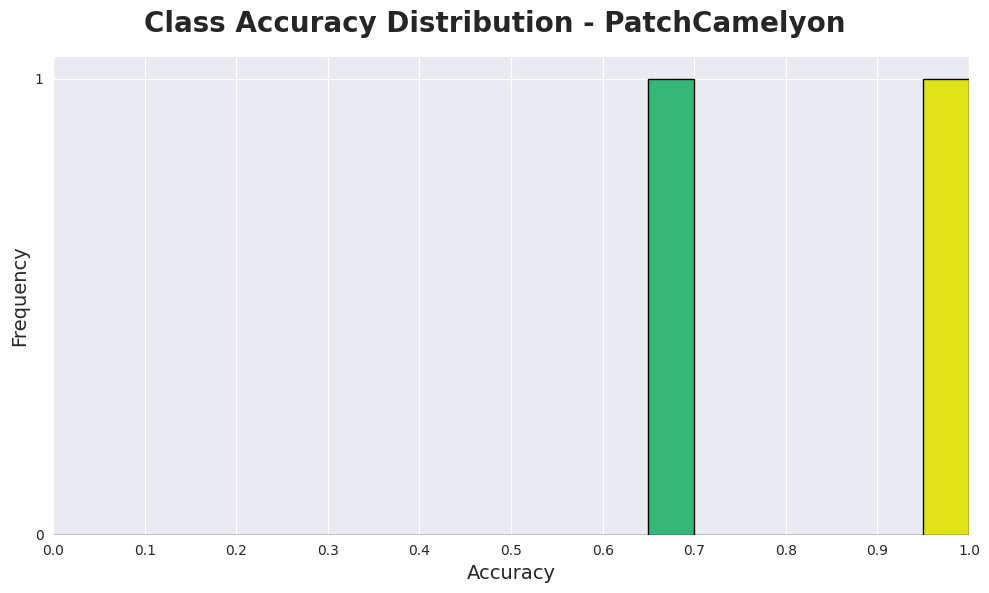

In [55]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [56]:
clip_sun397 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
get_model_params(clip_sun397)

Parameters: 86.10M


In [58]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 9516/9516 [21:41<00:00,  7.31it/s]


Epochs: 1/10 | train_loss: 1.9732 | train_acc: 0.5199


100%|██████████| 9516/9516 [19:56<00:00,  7.96it/s]


Epochs: 2/10 | train_loss: 1.0496 | train_acc: 0.7000


100%|██████████| 9516/9516 [19:44<00:00,  8.03it/s]


Epochs: 3/10 | train_loss: 0.7434 | train_acc: 0.7760


100%|██████████| 9516/9516 [19:36<00:00,  8.09it/s]


Epochs: 4/10 | train_loss: 0.5392 | train_acc: 0.8300


100%|██████████| 9516/9516 [19:40<00:00,  8.06it/s]


Epochs: 5/10 | train_loss: 0.4020 | train_acc: 0.8709


100%|██████████| 9516/9516 [19:36<00:00,  8.09it/s]


Epochs: 6/10 | train_loss: 0.3178 | train_acc: 0.8968


100%|██████████| 9516/9516 [19:34<00:00,  8.10it/s]


Epochs: 7/10 | train_loss: 0.2635 | train_acc: 0.9161


100%|██████████| 9516/9516 [19:38<00:00,  8.07it/s]


Epochs: 8/10 | train_loss: 0.2262 | train_acc: 0.9274


100%|██████████| 9516/9516 [19:36<00:00,  8.09it/s]


Epochs: 9/10 | train_loss: 0.2014 | train_acc: 0.9358


100%|██████████| 9516/9516 [19:28<00:00,  8.14it/s]


Epochs: 10/10 | train_loss: 0.1839 | train_acc: 0.9416


In [59]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [03:00<00:00, 15.10it/s]


test_loss: 1.6465 | test_acc: 0.6613


In [60]:
sun397_accs.append(sun397_acc)

In [61]:
get_top_5_accuracies(sun397_per_class_acc)

[('underwater (coral reef)', 0.9827586206896551),
 ('wave', 0.9636363636363636),
 ('sauna', 0.9629629629629629),
 ('cockpit', 0.9552238805970149),
 ('ball pit', 0.9523809523809523)]

In [62]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('gift shop', 0.03571428571428571),
 ('hunting lodge (outdoor)', 0.041666666666666664),
 ('library (outdoor)', 0.047619047619047616),
 ('forest (needleleaf)', 0.05714285714285714),
 ('biology laboratory', 0.09090909090909091)]

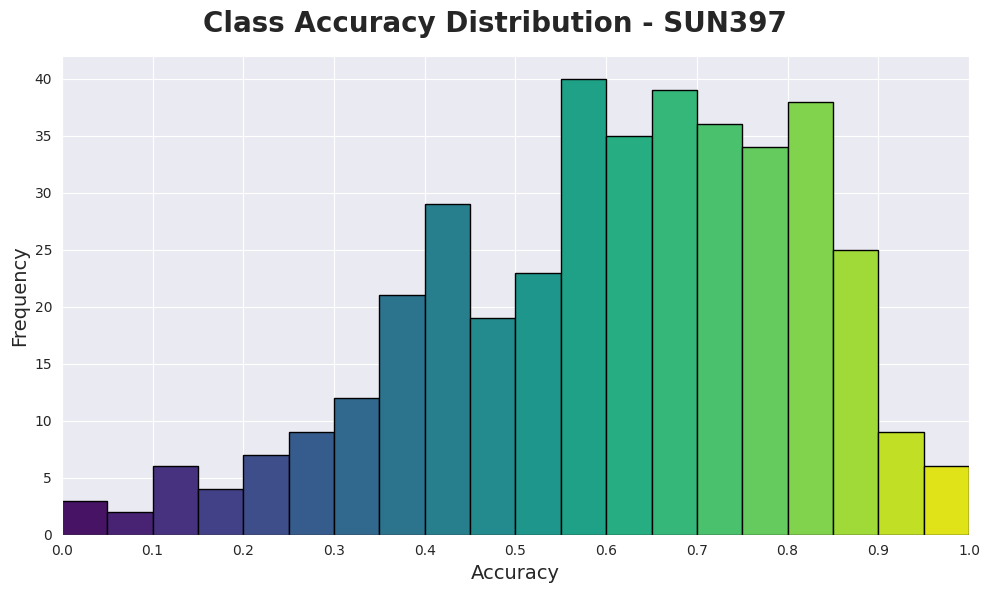

In [63]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [64]:
clip_dtd = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
get_model_params(clip_dtd)

Parameters: 85.84M


In [66]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 470/470 [00:59<00:00,  7.85it/s]


Epochs: 1/10 | train_loss: 1.9784 | train_acc: 0.4777


100%|██████████| 470/470 [00:57<00:00,  8.14it/s]


Epochs: 2/10 | train_loss: 0.9494 | train_acc: 0.7186


100%|██████████| 470/470 [00:57<00:00,  8.16it/s]


Epochs: 3/10 | train_loss: 0.5684 | train_acc: 0.8247


100%|██████████| 470/470 [00:58<00:00,  8.10it/s]


Epochs: 4/10 | train_loss: 0.3926 | train_acc: 0.8758


100%|██████████| 470/470 [00:57<00:00,  8.13it/s]


Epochs: 5/10 | train_loss: 0.3369 | train_acc: 0.8955


100%|██████████| 470/470 [00:57<00:00,  8.15it/s]


Epochs: 6/10 | train_loss: 0.2217 | train_acc: 0.9338


100%|██████████| 470/470 [00:58<00:00,  8.09it/s]


Epochs: 7/10 | train_loss: 0.1794 | train_acc: 0.9481


100%|██████████| 470/470 [00:57<00:00,  8.11it/s]


Epochs: 8/10 | train_loss: 0.1826 | train_acc: 0.9503


100%|██████████| 470/470 [00:57<00:00,  8.13it/s]


Epochs: 9/10 | train_loss: 0.2307 | train_acc: 0.9309


100%|██████████| 470/470 [00:57<00:00,  8.11it/s]

Epochs: 10/10 | train_loss: 0.1635 | train_acc: 0.9543


In [67]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:14<00:00, 16.01it/s]

test_loss: 1.4772 | test_acc: 0.6574


In [68]:
dtd_accs.append(dtd_acc)

In [69]:
get_top_5_accuracies(dtd_per_class_acc)

[('zigzagged', 1.0),
 ('studded', 0.925),
 ('frilly', 0.9),
 ('potholed', 0.9),
 ('cracked', 0.875)]

In [70]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('polka-dotted', 0.3),
 ('stained', 0.3),
 ('marbled', 0.4),
 ('scaly', 0.4),
 ('blotchy', 0.425)]

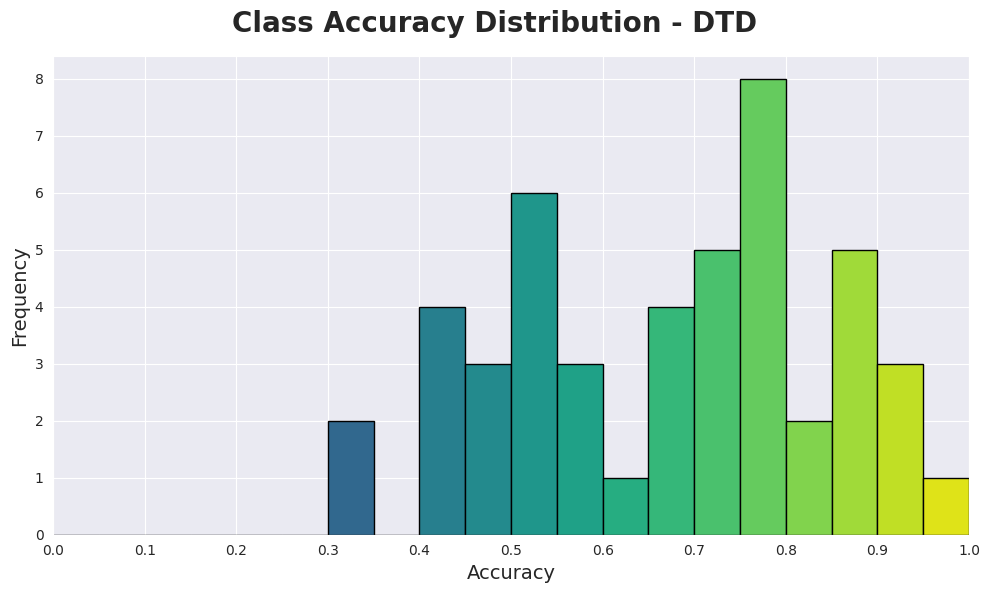

In [71]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [72]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [73]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [74]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [75]:
df = pd.DataFrame(results, columns=['fine-tuning'], index=labels)
df

,fine-tuning
RESISC45,0.879524
Food-101,0.794693
FER2013,0.686542
PatchCamelyon,0.833099
SUN397,0.661333
DTD,0.657447
